In [27]:
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split,  KFold, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

from copy import copy
import seaborn as sns
import matplotlib.pyplot as plt

### Structure of the problem task is:
X 
    - ['date', 'SKU', 'Category', 'geoCluster', 'Group', 'price']

Y
    - ['qty']


In [2]:
def apply_lr_ridge_lasso(sales):
    sales["year"] = sales.date.apply(lambda x: x.year)
    sales["month"] = sales.date.apply(lambda x: x.month)
    sales["week"] = sales.date.apply(lambda x: x.week)
    sales["day_of_week"] = sales.date.apply(lambda x: x.dayofweek)
    sales = sales.drop("date", axis="columns")

    # Convert categorical to numeric
    category = sales.Category.unique()
    category = zip(category, np.random.randint(1000,9999, size=(len(category))))
    category = dict(category)
    sales.replace({"Category": category}, inplace=True)

    group = sales.Group.unique()
    group = zip(group, np.random.randint(1000,9999, size=(len(group))))
    group= dict(group)
    sales.replace({"Group": group}, inplace=True)

    # Split dataset
    X = sales.loc[:, sales.columns != 'qty']
    y = sales['qty']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    print(f"Average qty train: {np.average(y_train):.3}")
    
    # define hyperparameter
    lambdas = [1e-10,1e-5,1e-4,1e-3,1e-2,0.1, 0.5,1,5,10,50,100]
        
    # --- Linear Reression
    kf = KFold(n_splits=5)
    i=1
    fold_mse = []
    fold_r2 = []
    for train_index, test_index in kf.split(X_train):
#         print('Split {}: \n\tTest Folds: [{}] \n\tTrain Folds {}'.format(i, i, [j for j in range(1,6) if j != i]))
        x_train_fold = X_train.values[train_index]
        y_train_fold = y_train.values[train_index]
        x_test_fold = X_train.values[test_index,:]
        y_test_fold = y_train.values[test_index]

        lr = LinearRegression()
        lr.fit(x_train_fold, y_train_fold)
        y_pred_fold = lr.predict(x_test_fold)
        fold_mse.append( mean_squared_error(y_test_fold, y_pred_fold) )
        fold_nmse =  1-r2_score(y_test_fold, y_pred_fold)
        fold_r2.append( r2_score(y_test_fold, y_pred_fold))
    # Train for later
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    print(f'Linear Regression Avg R2 score: {np.average(fold_r2):.3}', f"MSE: {np.average(fold_mse):.3}")
#     print('Linear Regression Avg R2 score:', fold_r2)
    
    # --- Ridge
    ridge_cv = RidgeCV(alphas=lambdas, cv=5)
    ridge_cv.fit(X_train, y_train)
    y_pred = ridge_cv.predict(X_train)
    ridge_mse = mean_squared_error(y_train, y_pred)
    ridge_r2 =  np.mean(cross_val_score(ridge_cv, X_train, y_train))
    print('Ridge Best lambda:', ridge_cv.alpha_, 'Avg R2 score:', ridge_r2, f'MSE: {ridge_mse:.3}')
    
    # --- Lasso
    lasso_cv = LassoCV(alphas=lambdas, cv=5)
    lasso_cv.fit(X_train, y_train)
    y_pred = lasso_cv.predict(X_train)
    lasso_mse = mean_squared_error(y_train, y_pred)
    lasso_r2 =  np.mean(cross_val_score(lasso_cv, X_train, y_train))
    print('Lasso Best lambda:', lasso_cv.alpha_, 'Avg R2 score:',lasso_r2, f'MSE: {lasso_mse:.3}')


    # Testing on test dataset
    print(f' ---- Running model on Test DataSet ----')
    
    print(f"Average qty test: {np.average(y_test):.3}")
    print("")
    # Linear Regression
    y_test_pred = lr.predict(X_test)
    # ----------------
    y_test_pred = pd.Series(y_test_pred, name="qty^")
    y_test_pred.index = y_test.index
    
    df = pd.concat([X_test, y_test, y_test_pred], axis='columns')
    df.to_csv("temp_1.csv")
    # ----------------
    lr_test_r2 = r2_score(y_test, y_test_pred)
    lr_mse = mean_squared_error(y_test, y_test_pred)
#     plot_2_lines(y_test, y_test_pred)
    print(f'lr_test_r2: {lr_test_r2:.3}  MSE: {lr_mse:.3}')
    
    # Ridge
    y_test_pred = ridge_cv.predict(X_test)
    ridge_test_r2 = r2_score(y_test, y_test_pred)
    ridge_mse = mean_squared_error(y_test, y_test_pred)
#     plot_2_lines(y_test, y_test_pred)
    print(f'ridge_test_r2: {ridge_test_r2:.3} MSE: {ridge_mse:.3}')
    
    # LASSO
    y_test_pred = lasso_cv.predict(X_test)
    lasso_test_r2 = r2_score(y_test, y_test_pred)
    lasso_mse = mean_squared_error(y_test, y_test_pred)
#     plot_2_lines(y_test, y_test_pred)
    print(f'lasso_test_r2: {lasso_test_r2:.3} MSE: {lasso_mse:.3}')
    
    return lr

In [29]:
scaler = StandardScaler()
sales = scaler.fit_transform(sales)

In [31]:
sales.shape

(688454, 10)

In [24]:
# # def apply_ml(sales):
# print(f'DataSet: imputed_v3.csv')
# sales = pd.read_csv("../data/processed/nts_imputed_v3.csv", parse_dates=['date'])
# sales["year"] = sales.date.apply(lambda x: x.year)
# sales["month"] = sales.date.apply(lambda x: x.month)
# sales["week"] = sales.date.apply(lambda x: x.week)
# sales["day_of_week"] = sales.date.apply(lambda x: x.dayofweek)
# sales = sales.drop("date", axis="columns")

# # Convert categorical to numeric
# category = sales.Category.unique()
# category = zip(category, np.random.randint(1000,9999, size=(len(category))))
# category = dict(category)
# sales.replace({"Category": category}, inplace=True)

# group = sales.Group.unique()
# group = zip(group, np.random.randint(1000,9999, size=(len(group))))
# group= dict(group)
# sales.replace({"Group": group}, inplace=True)

# # Split dataset
# X = sales.loc[:, sales.columns != 'qty']
# y = sales['qty']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


# --- Neural Network


# --- scaler
sale
regr = MLPRegressor(hidden_layer_sizes=(12, 2), max_iter=7_000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_train)
nn_score = regr.score(X_train, y_train)
nn_mse = mean_squared_error(y_train, y_pred)
nn_r2 = r2_score(y_train, y_pred)
print(f" +++++++++++++")
print(f'Nueral Net Score: {nn_score}')
print(f"MSE: {nn_mse}")
print(f"R2 Score: {nn_r2}")
print(f"Sum of y_pred: {sum(y_pred)}")
print(f"Sum of y_train: {sum(y_train)}")
print(f"Diffs of Sum: {abs( sum(y_pred) - sum(y_train))}")
print(f" +++++++++++++")

 +++++++++++++
Nueral Net Score: -6.942942310628197e-06
MSE: 22.13534406725743
R2 Score: -6.942942310628197e-06
Sum of y_pred: 2196773.567745835
Sum of y_train: 2189945.809000184
Diffs of Sum: 6827.7587456512265
 +++++++++++++


Nueral Net Score: -1.723927622876431e-08
MSE: 22.135190765502223
R2 Score: -1.723927622876431e-08
Sum of y_pred: 2190286.033722403
Sum of y_train: 2189945.809000184
Diffs of Sum: 340.2247222191654


In [25]:
y_pred = pd.Series(y_pred, name="qty^")
y_pred.index = y_train.index

In [26]:
pd.concat([y_train, y_pred], axis=1).to_csv("temp.csv")

In [25]:
print(f'DataSet: nts_v1.csv')
sales = pd.read_csv("../data/processed/nts_v1.csv", parse_dates=['date'])
# apply_lr_ridge_lasso(sales)
# apply_ml(sales)

print("")

print(f'DataSet: nts__outliers_removed_v2.csv')
sales = pd.read_csv("../data/processed/nts__outliers_removed_v2.csv", parse_dates=['date'])
# apply_lr_ridge_lasso(sales)
# apply_ml(sales)

print("")

print(f'DataSet: imputed_v3.csv')
sales = pd.read_csv("../data/processed/nts_imputed_v3.csv", parse_dates=['date'])
# best_model = apply_lr_ridge_lasso(sales)
apply_ml(sales)

DataSet: nts_v1.csv

DataSet: nts__outliers_removed_v2.csv

DataSet: imputed_v3.csv
 +++++++++++++
Nueral Net Score: 0.08774958244269926
MSE: 20.192836670430022
R2 Score: 0.08774958244269926
 +++++++++++++


## Running best model on Test.csv

In [85]:
print(f'DataSet: imputed_v3.csv')
sales_og_test = pd.read_csv("../data/processed/test_data_processed.csv", parse_dates=['date'])
sales_test = copy(sales_og_test)
sales_test["year"] = sales_test.date.apply(lambda x: x.year)
sales_test["month"] = sales_test.date.apply(lambda x: x.month)
sales_test["week"] = sales_test.date.apply(lambda x: x.week)
sales_test["day_of_week"] = sales_test.date.apply(lambda x: x.dayofweek)
sales_test = sales_test.drop("date", axis="columns")

# Convert categorical to numeric
category = sales_test.Category.unique()
category = zip(category, np.random.randint(1000,9999, size=(len(category))))
category = dict(category)
sales_test.replace({"Category": category}, inplace=True)

group = sales_test.Group.unique()
group = zip(group, np.random.randint(1000,9999, size=(len(group))))
group= dict(group)
sales_test.replace({"Group": group}, inplace=True)

# Split dataset
X = sales_test.loc[:, sales_test.columns != 'qty']
y = sales_test['qty']


y_pred = best_model.predict(X)


DataSet: imputed_v3.csv


In [86]:
y_pred = pd.DataFrame(y_pred, columns=['qty'])
sales_og_test['qty'] = y_pred

In [93]:
y_pred.to_csv("temp.csv")

In [100]:
sales_og_test.to_csv("../data/processed/test_submission.csv", index=False)

# Merge 2 DFs

In [110]:
df = pd.read_csv("dollar_val.csv")
geoParams = pd.read_csv("../data/raw/geo_params.csv", header=0, delimiter=",")
df = pd.merge(df, geoParams, how='inner')
df.to_csv("../data/processed/dollar_v2.csv", index=False)

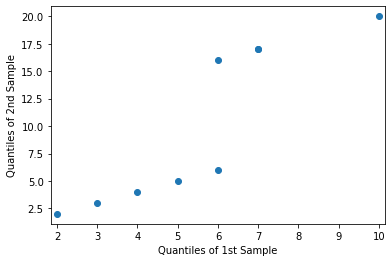

In [58]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot_2samples

#----------------------------------------------------------------
# GRAPH
#----------------------------------------------------------------
a = [2, 3, 4, 5, 6, 6, 7, 7, 10]
b = [2, 3, 4, 5, 6, 16, 17, 17, 20]

def plot_2_lines(a, b):
    x = np.array(a)
    y = np.array(b)
    pp_x = sm.ProbPlot(x)
    pp_y = sm.ProbPlot(y)
    qqplot_2samples(pp_x, pp_y)
    plt.show()

plot_2_lines(a, b)